### 1. Setup e Carga de Dados (Célula 1)

Esta célula importa as ferramentas necessárias (como pandas para manipular tabelas e sklearn para a Inteligência Artificial) e carrega os arquivos brutos do MovieLens (u.data com as notas e u.item com os nomes dos filmes) para a memória do computador.

In [3]:
# Célula 1: Setup e Carga de Dados
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Configuração para gráficos 
sns.set_style("whitegrid")

# --- 1. Carregar Avaliações ---
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')

# --- 2. Carregar Filmes e Gêneros ---
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 
          'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 
          'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, encoding='latin-1')

# Guardar os nomes das colunas de gênero para uso posterior
genre_cols = m_cols[5:] 

print("--- Dados Carregados ---")
print(f"Total de Avaliações: {len(ratings)}")
print(f"Total de Filmes: {len(movies)}")
print(f"Total de Usuários: {ratings['user_id'].nunique()}")
print("\nExemplo dos dados de filmes:")
display(movies[['movie_id', 'title'] + genre_cols[:3]].head(3))

--- Dados Carregados ---
Total de Avaliações: 100000
Total de Filmes: 1682
Total de Usuários: 943

Exemplo dos dados de filmes:


,movie_id,title,unknown,Action,Adventure
0,1,Toy Story (1995),0,0,0
1,2,GoldenEye (1995),0,1,1
2,3,Four Rooms (1995),0,0,0


### 2. Pré-Processamento (Célula 2)

Aqui ocorre a transformação dos dados para um formato que a IA entenda.

    Pivotagem: Transforma a lista de notas em uma matriz onde cada linha é um usuário e cada coluna é um filme.

    Limpeza: Substitui valores vazios (filmes não vistos) por zero.

    Padronização (StandardScaler): Coloca todas as notas na mesma escala matemática para que usuários críticos e generosos sejam comparados de forma justa.

In [4]:
# Célula 2: Pré-Processamento

print("--- Iniciando Pré-Processamento ---")

# 1. Pivotar: Transformar em Matriz Usuário x Filme
user_movie_matrix = ratings.pivot_table(
    index='user_id', 
    columns='movie_id', 
    values='rating'
)

# 2. Tratar Nulos: Substituir NaN (não avaliado) por 0
user_movie_matrix = user_movie_matrix.fillna(0)

# 3. Padronizar: Colocar tudo na mesma escala (Z-score)
scaler = StandardScaler()
user_movie_matrix_scaled = scaler.fit_transform(user_movie_matrix)

print("Matriz criada e padronizada com sucesso.")
print(f"Dimensões da Matriz: {user_movie_matrix.shape} (Usuários x Filmes)")

--- Iniciando Pré-Processamento ---
Matriz criada e padronizada com sucesso.
Dimensões da Matriz: (943, 1682) (Usuários x Filmes)


### 3. Modelagem e Definição de K (Célula 3)

Este é o "cérebro" do projeto. O código utiliza o Silhouette Score para testar automaticamente diferentes quantidades de grupos (entre 5 e 15) e decidir qual número (K) gera a melhor separação matemática. Em seguida, ele treina o modelo K-Means definitivo com esse número ideal e atribui cada usuário a um grupo.

In [5]:
# Célula 3: Definição Automática de K (Com Mínimo de Grupos)

from sklearn.metrics import silhouette_score

print("--- Buscando o número ideal de grupos (K) ---")
print("Restrição de Negócio: Testando apenas entre 5 e 15 grupos.")

best_k = 5 
best_score = -1
scores = []


K_range = range(5, 16) 

for k in K_range:
    # Treinar um K-Means temporário
    kmeans_temp = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_temp.fit(user_movie_matrix_scaled)
    
    # Calcular o Silhouette Score
    score = silhouette_score(user_movie_matrix_scaled, kmeans_temp.labels_)
    scores.append(score)
    
    print(f"K={k}: Score = {score:.4f}")
    
    # Se esse score for melhor que o anterior, atualizamos
    if score > best_score:
        best_score = score
        best_k = k

print("-" * 30)
print(f"O código decidiu! Dentro da faixa permitida, o melhor K é: {best_k}")
print("-" * 30)

# --- Treinamento Final com o Melhor K ---
print(f"Treinando modelo final com K={best_k}...")

K = best_k # A variável K agora recebe o valor escolhido

kmeans_final = KMeans(
    n_clusters=K, 
    n_init=10, 
    random_state=42
)
kmeans_final.fit(user_movie_matrix_scaled)

# Atribuir os grupos aos usuários
user_movie_matrix['cluster'] = kmeans_final.labels_ + 1

print("Agrupamento concluído.")
print("\nQuantidade de usuários por grupo:")
print(user_movie_matrix['cluster'].value_counts().sort_index())

--- Buscando o número ideal de grupos (K) ---
Restrição de Negócio: Testando apenas entre 5 e 15 grupos.


C:\Users\abdieljunio\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\abdieljunio\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\abdieljunio\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\abdieljunio\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~

K=5: Score = 0.2230


C:\Users\abdieljunio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K=6: Score = 0.2106


C:\Users\abdieljunio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K=7: Score = 0.3067


C:\Users\abdieljunio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K=8: Score = 0.2665


C:\Users\abdieljunio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K=9: Score = 0.2832


C:\Users\abdieljunio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K=10: Score = 0.1387


C:\Users\abdieljunio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K=11: Score = 0.1056


C:\Users\abdieljunio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K=12: Score = 0.1352


C:\Users\abdieljunio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K=13: Score = 0.2603


C:\Users\abdieljunio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K=14: Score = 0.1340


C:\Users\abdieljunio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K=15: Score = 0.2545
------------------------------
O código decidiu! Dentro da faixa permitida, o melhor K é: 7
------------------------------
Treinando modelo final com K=7...


C:\Users\abdieljunio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Agrupamento concluído.

Quantidade de usuários por grupo:
cluster
1     60
2      1
3      1
4      1
5    135
6    744
7      1
Name: count, dtype: int64


### 4. Visualização dos Clusters (Célula 4)

Como não podemos visualizar um gráfico com 1.682 dimensões (filmes), usamos o PCA para resumir tudo em 2 dimensões (X e Y). O gráfico de dispersão gerado mostra uma amostra dos usuários colorida por grupo, permitindo ver visualmente se o algoritmo conseguiu separar bem os perfis de gosto.

--- Gerando Visualização 2D ---


C:\Users\abdieljunio\AppData\Local\Temp\ipykernel_15384\565854496.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = plot_df.groupby('cluster', group_keys=False).apply(


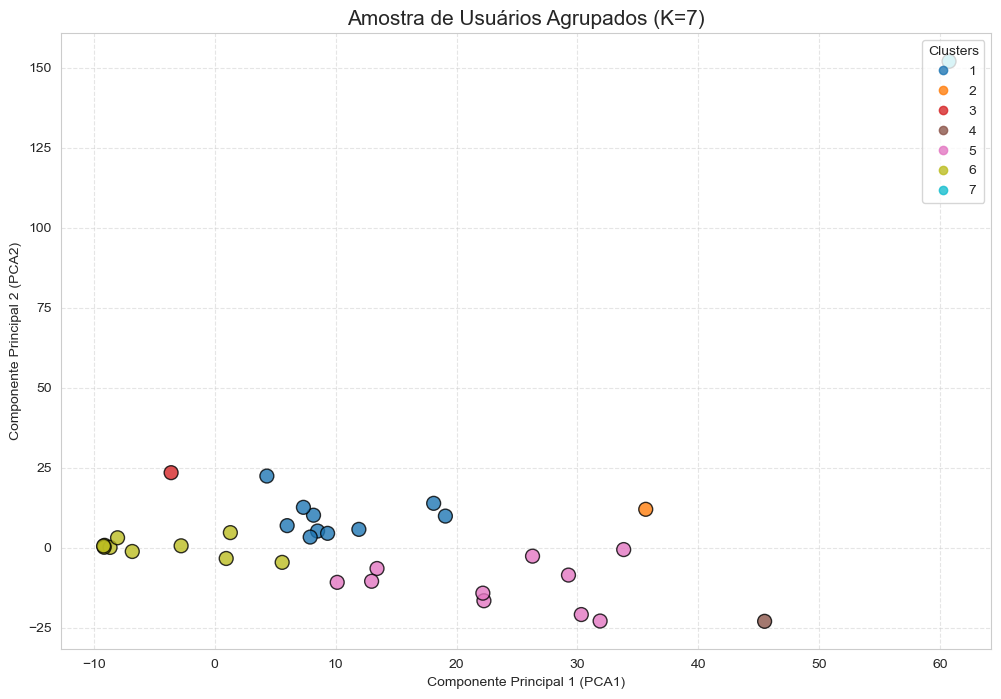

In [6]:
# Célula 4: Visualização dos Clusters (Gráfico de Dispersão)

print("--- Gerando Visualização 2D ---")

# 1. Reduzir as dimensões de ~1600 para 2 (usando PCA)
pca = PCA(n_components=2, random_state=42)
data_2d = pca.fit_transform(user_movie_matrix_scaled)

# 2. Criar DataFrame temporário para o gráfico
plot_df = pd.DataFrame(data=data_2d, columns=['PCA1', 'PCA2'], index=user_movie_matrix.index)
plot_df['cluster'] = user_movie_matrix['cluster']

# 3. Pegar uma amostra (10 usuários por grupo) para não poluir o gráfico
samples_per_group = 10
sampled_df = plot_df.groupby('cluster', group_keys=False).apply(
    lambda x: x.sample(min(len(x), samples_per_group), random_state=42)
)

# 4. Plotar
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    sampled_df['PCA1'], 
    sampled_df['PCA2'], 
    c=sampled_df['cluster'], 
    cmap='tab10', 
    s=100, 
    alpha=0.8, 
    edgecolors='k'
)

plt.title(f'Amostra de Usuários Agrupados (K={K})', fontsize=15)
plt.xlabel('Componente Principal 1 (PCA1)')
plt.ylabel('Componente Principal 2 (PCA2)')
plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### 5. Estatísticas do Dataset (Célula 5 e 6)

Uma etapa de análise exploratória para conhecer os dados. Gera gráficos que mostram a Atividade dos Usuários (Quantos filmes cada um avaliou?), Quantidade de Filmes Lançados por Ano (1950+), Distribuição Geral das Notas (1 a 5) e Top 10 Gêneros no Acervo.


--- Gerando Estatísticas Adicionais ---


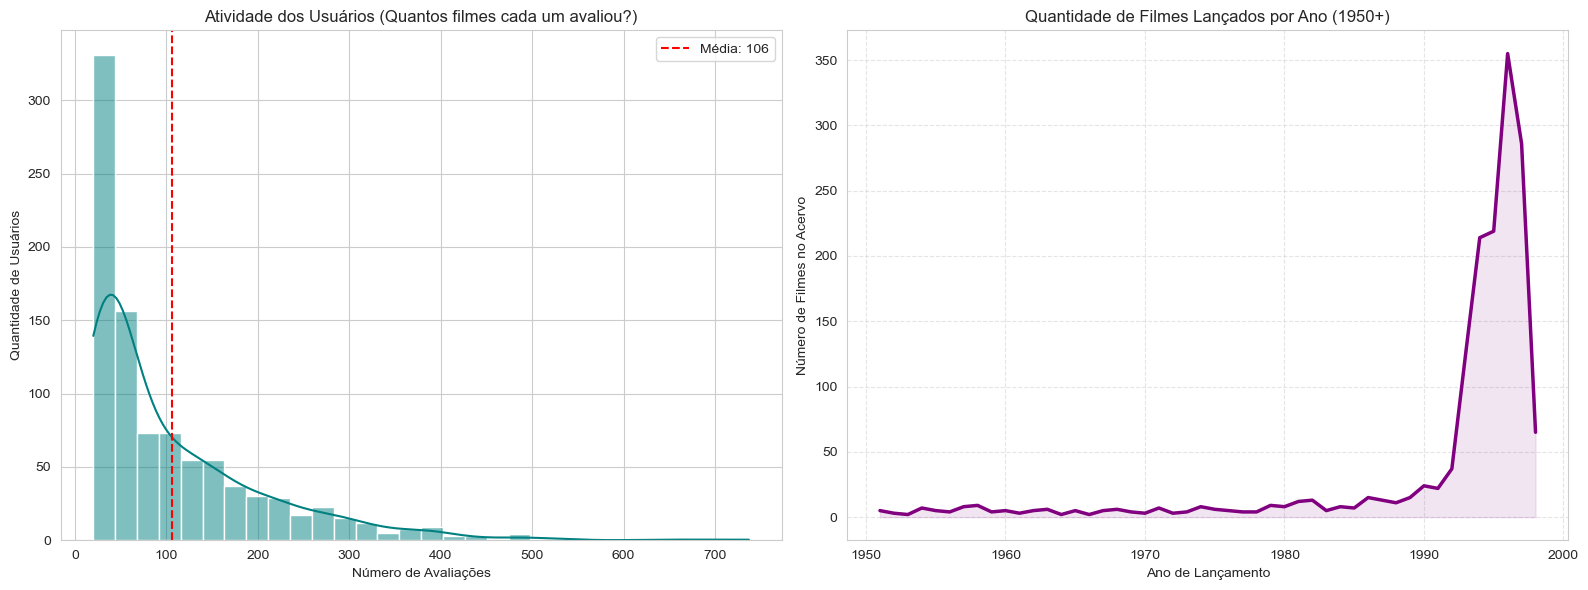

In [7]:
# --- Célula 5: Estatísticas Gerais do Dataset ---

print("\n--- Gerando Estatísticas Adicionais ---")
plt.figure(figsize=(16, 6))

# 1. Preparar dados: Extrair o ANO de lançamento dos filmes
# O formato da data é '01-Jan-1995'. Vamos pegar os últimos 4 dígitos.
# errors='coerce' vai transformar erros (datas vazias) em NaT (Not a Time)
movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').dt.year

# GRÁFICO 3: Atividade dos Usuários (Quantas avaliações cada um fez?)
plt.subplot(1, 2, 1)
user_activity = ratings.groupby('user_id')['rating'].count()
sns.histplot(user_activity, bins=30, kde=True, color='teal')
plt.title('Atividade dos Usuários (Quantos filmes cada um avaliou?)')
plt.xlabel('Número de Avaliações')
plt.ylabel('Quantidade de Usuários')
# Adicionar uma linha vertical na média
plt.axvline(user_activity.mean(), color='red', linestyle='--', label=f'Média: {user_activity.mean():.0f}')
plt.legend()

# GRÁFICO 4: Distribuição de Filmes por Ano
plt.subplot(1, 2, 2)
# Contar filmes por ano e ordenar pelo ano
movies_per_year = movies['year'].value_counts().sort_index()
# Filtrar para mostrar apenas anos com relevância (focado nos últimos 50 anos do dataset para legibilidade.)
movies_per_year = movies_per_year[movies_per_year.index > 1950]

sns.lineplot(x=movies_per_year.index, y=movies_per_year.values, color='purple', linewidth=2.5)
plt.fill_between(movies_per_year.index, movies_per_year.values, color='purple', alpha=0.1)
plt.title('Quantidade de Filmes Lançados por Ano (1950+)')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Número de Filmes no Acervo')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

C:\Users\abdieljunio\AppData\Local\Temp\ipykernel_15384\3121193118.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ratings_counts.index, y=ratings_counts.values, palette='viridis')
C:\Users\abdieljunio\AppData\Local\Temp\ipykernel_15384\3121193118.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='magma')


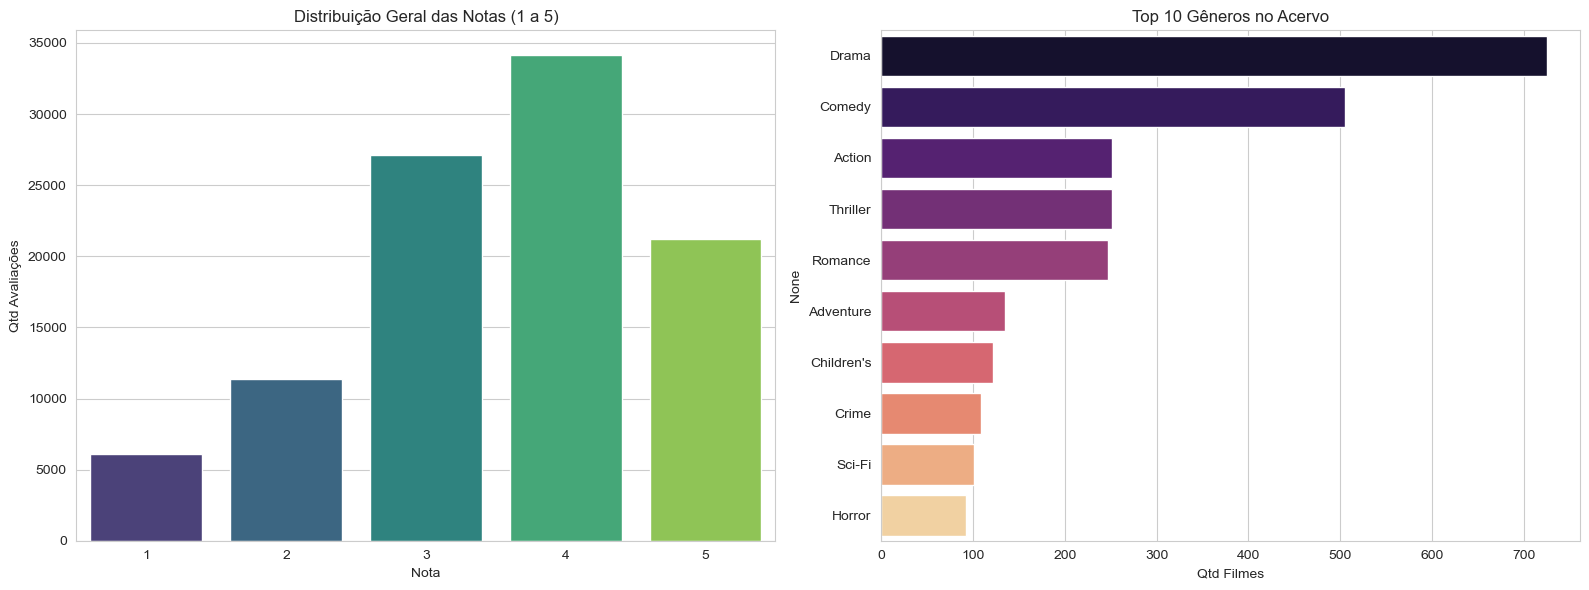

In [8]:
# Célula 6: Mais Estatísticas Gerais

plt.figure(figsize=(16, 6))

# Gráfico 1: Distribuição das Notas
plt.subplot(1, 2, 1)
ratings_counts = ratings['rating'].value_counts().sort_index()
sns.barplot(x=ratings_counts.index, y=ratings_counts.values, palette='viridis')
plt.title('Distribuição Geral das Notas (1 a 5)')
plt.xlabel('Nota')
plt.ylabel('Qtd Avaliações')

# Gráfico 2: Top 10 Gêneros
plt.subplot(1, 2, 2)
# Somar as colunas de gênero para ver quais têm mais filmes
genre_counts = movies[genre_cols].sum().sort_values(ascending=False).head(10)
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='magma')
plt.title('Top 10 Gêneros no Acervo')
plt.xlabel('Qtd Filmes')

plt.tight_layout()
plt.show()

### 6.Recomendação (Célula 7)

A etapa final de Aplicação. Esta função analisa cada um dos grupos formados, identifica quais filmes foram mais bem avaliados (5 estrelas) pelos membros daquele grupo e gera:

    1. Um Perfil de Gênero (ex: "Este grupo prefere Drama e Ação").

    2. Uma lista Top 5 Filmes recomendados especificamente para aquele perfil.

In [9]:
# Célula 6: Gerar Recomendações e Perfis

def recomendar_para_grupo(cluster_id, n_recommendations=5):
    # 1. Identificar usuários do grupo
    cluster_users = user_movie_matrix[user_movie_matrix['cluster'] == cluster_id].index
    
    # 2. Filtrar filmes com nota 5 dados por esse grupo
    cluster_ratings = ratings[
        (ratings['user_id'].isin(cluster_users)) & 
        (ratings['rating'] == 5)
    ]
    
    # 3. Contar os filmes mais populares (Top Filmes)
    recommended_movie_ids = cluster_ratings['movie_id'].value_counts()
    final_recs = pd.merge(
        recommended_movie_ids.head(n_recommendations), 
        movies, 
        left_index=True, 
        right_on='movie_id'
    )
    
    # 4. Calcular o Perfil de Gênero (Quais gêneros esses filmes pertencem?)
    all_liked_ids = cluster_ratings['movie_id'].unique()
    liked_details = movies[movies['movie_id'].isin(all_liked_ids)]
    genre_profile = liked_details[genre_cols].sum().sort_values(ascending=False).head(3)
    
    # --- EXIBIÇÃO ---
    print(f"\n{'='*40}")
    print(f"📂 GRUPO {cluster_id}")
    print(f"{'='*40}")
    
    print(f"🎭 Gêneros Favoritos: {', '.join(genre_profile.index.tolist())}")
    
    print("\n🎬 Top 5 Filmes Recomendados:")
    print(final_recs[['title']].to_string(index=False, header=False))

# Loop para gerar recomendações para todos os grupos
for i in range(1, K + 1):
    recomendar_para_grupo(cluster_id=i)


📂 GRUPO 1
🎭 Gêneros Favoritos: Drama, Comedy, Romance

🎬 Top 5 Filmes Recomendados:
    Casablanca (1942)
  Citizen Kane (1941)
   Rear Window (1954)
Godfather, The (1972)
 Graduate, The (1967)

📂 GRUPO 2
🎭 Gêneros Favoritos: Drama, Comedy, Thriller

🎬 Top 5 Filmes Recomendados:
      Hudsucker Proxy, The (1994)
                     Speed (1994)
     2001: A Space Odyssey (1968)
E.T. the Extra-Terrestrial (1982)
                      Babe (1995)

📂 GRUPO 3
🎭 Gêneros Favoritos: Drama, Action, Romance

🎬 Top 5 Filmes Recomendados:
        G.I. Jane (1997)
          Titanic (1997)
Conspiracy Theory (1997)
Good Will Hunting (1997)

📂 GRUPO 4
🎭 Gêneros Favoritos: Comedy, Action, Thriller

🎬 Top 5 Filmes Recomendados:
                                        Monty Python's Life of Brian (1979)
                                                Arsenic and Old Lace (1944)
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)
                                                 